# Numpy 1D-DFT
- reference: http://dcwww.camd.dtu.dk/~askhl/files/python-dft-exercises.pdf
- Goal: write our own Kohn-Sham (KS) DFT code
    - Target: a harmonic oscillator including kinetic energy, electrostatic repulsion between the electrons, and the local density approximation for electronic interactions, ignoring correlation.
    - Hamiltonian:
    
$$\hat{H}=-\frac{1}{2}\frac{d^2}{dx^2}+v(x)\\
v(x)=v_{Ha}(x)+v_{LDA}(x)+x^2$$

- first term is kinetic energy
- $v_{LDA}$ is the local density approximation for electronic interactions, ignoring correlation
- $v_{ext}(x) = x^2$ is  the external potential 

- What we have to do?
    1. Represent the Hamiltonian
    1. Calculate the KS wavefunctions, the density

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style("white")

# Differential operator
- In order to represent kinetic operator
- In this section, our goal is to differentiate a sin curve, represented as a grid function as folllows:

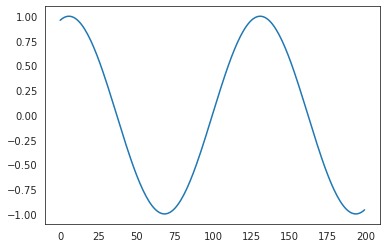

In [86]:
n_grid=200
x=np.linspace(-5,5,n_grid)
y=np.sin(x)
plt.plot(y)

### First order differentiation

- approximate:

$$(\frac{dy}{dx})_{i}=\frac{y_{i+1}-{y_{i}}}{h}$$

- then:

$$D_{ij}=\frac{\delta_{i+1,j}-\delta_{i,j}}{h}$$

- we could write as follows:

$$(\frac{dy}{dx})_{i}=D_{ij} y_{j}$$


- The derivative may not be well defined at the end of the grid.
- $\delta_{ij}$ is Kronecker delta
- Einstein summation is used for last equation

In [87]:
h=x[1]-x[0]
D=-np.eye(n_grid)+np.diagflat(np.ones(n_grid-1),1)
D = D / h

### Second oorder differentiation

- In the same way as the first order:

$$D^2_{ij}=\frac{\delta_{i+1,j}-2\delta_{i,j}+\delta_{i-1,j}}{h^2}$$

- This could be written with the first order $D_{ij}$, as follows (take care of the transpose):

$$D^2_{ij}=-D_{ik}D_{jk}$$

- The derivative may not be well defined at the end of the grid.

In [88]:
D2=D.dot(-D.T)
D2[-1,-1]=D2[0,0]

### confirmation plots

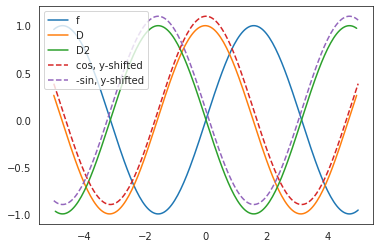

In [89]:
sns.set_style("white")
plt.plot(x,y, label="f")
plt.plot(x[:-1],D.dot(y)[:-1], label="D")
plt.plot(x[1:-1],D2.dot(y)[1:-1], label="D2")
plt.plot(x, np.cos(x)+0.1, '--', label='cos, y-shifted')
plt.plot(x, -np.sin(x)+0.1, '--', label='-sin, y-shifted')
plt.legend()

# Non-interacting electrons
- This is the Hamiltonian of non-interacting free particles in a box given by the size of grid:
$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2}$$

- We could solve the KS equation as follows:

In [90]:
eig_non, psi_non=np.linalg.eigh(-D2/2)
# eig_non are the eigenvalues in ascending order, repeated according to its multiplicity
# psi_non[:,i] is the normalized eigenvector corresponding to the eigenvalue eig_non[i]

- plot (energies are shown in the label)

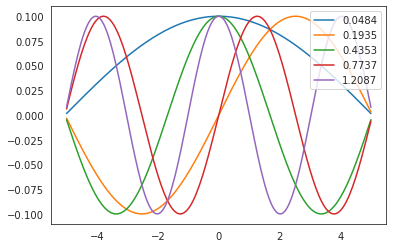

In [91]:
for i in range(5): # 5 lowest eigen energies
    plt.plot(x,psi_non[:,i], label=f"{eig_non[i]:.4f}")
    plt.legend(loc=1)

# Harmonic oscillator
- include the external potential $v_{ext}=x^2$:
$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2} + x^2$$

- we can write the potential as a matrix $X$, as follows:

In [92]:
X=np.diagflat(x*x)

- and solve the KS.

In [93]:
eig_harm, psi_harm = np.linalg.eigh(-D2/2+X)

- plot

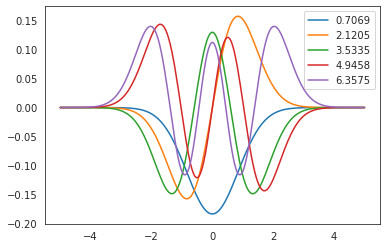

In [94]:
for i in range(5):
    plt.plot(x,psi_harm[:,i], label=f"{eig_harm[i]:.4f}")
    plt.legend(loc=1)

## matches with theory for first low energy

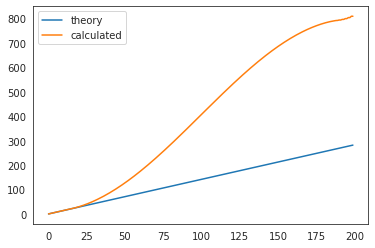

In [95]:
hbar = 1
omega = np.sqrt(2)

# E_n = (2n+1)hbar/2 * omega
E_theory = [(2*n+1)*hbar/2 * omega for n in range(len(x))]

plt.figure()
plt.plot(E_theory, label='theory')
plt.plot(eig_harm, label='calculated')
plt.legend()
plt.show()

# Well potential

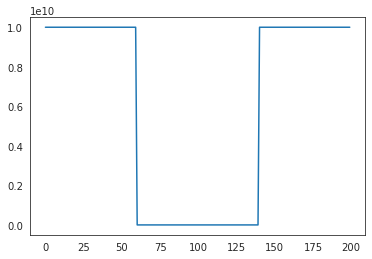

In [96]:
w=np.full_like(x,1e10)
w[np.logical_and(x>-2,x<2)]=0.
plt.plot(w)

- solve the KS

In [97]:
eig_well, psi_well= np.linalg.eigh(-D2/2+np.diagflat(w))

- plot

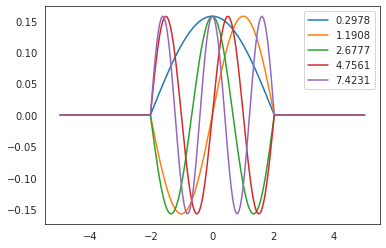

In [98]:
for i in range(5):
    plt.plot(x,psi_well[:,i], label=f"{eig_well[i]:.4f}")
    plt.legend(loc=1)

## matches with theory for first low energy
for higher energy the dicretization error is too big

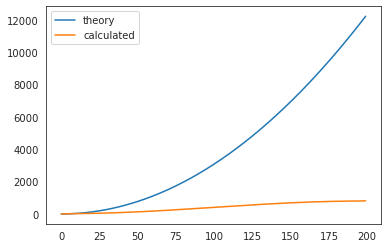

In [99]:
d = 4

# E_n = (2n+1)hbar/2 * omega
E_theory = [0.5*(n*np.pi/d)**2 for n in range(len(x))]

plt.figure()
plt.plot(E_theory, label='theory')
plt.plot(eig_harm, label='calculated')
plt.legend()
plt.show()

# Density
- We will want to include the Coulomb or Hatree interacion as well as LDA exchange
- Both of which are density functionals
- So we need to calculate the electron density
- Each state should be normalized:
$$\int \lvert \psi \rvert ^2 dx = 1$$

- let $f_n$ be occupation numbers, the density $n(x)$ can be written as follows:
$$n(x)=\sum_n f_n \lvert \psi(x) \rvert ^2 $$

- Note:
    - Each state fits up to two electrons: one with spin up, and one with spin down.
    - In DFT, we calculate the ground state.
    - for fermions the occupation number can only be 0 or 1,2 (corrsponding to not occupied, only one electron or two electrons with opposite spins)
    - for bosons the occupation number is the number of particles in a certain fock state

In [100]:
# integral
def integral(x,y,axis=0):
    dx=x[1]-x[0]
    return np.sum(y*dx, axis=axis)

- number of electrons

In [101]:
num_electron=17

- density

In [104]:
def get_nx(num_electron, psi, x): # function to compute the electron density n(x)
    # normalization
    I=integral(x,psi**2,axis=0)
    normed_psi=psi/np.sqrt(I)[None, :]
    
    # occupation num
    # fill lowest energy eigenstates first with 2
    # if number of states is odd, add last states
    fn=[2 for _ in range(num_electron//2)]
    if num_electron % 2:
        fn.append(1)

    # density
    res=np.zeros_like(normed_psi[:,0])
    for ne, psi  in zip(fn,normed_psi.T):
        res += ne*(psi**2)
    return res

- plot

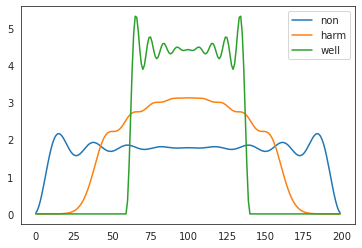

In [103]:
plt.plot(get_nx(num_electron,psi_non, x), label="non")
plt.plot(get_nx(num_electron,psi_harm, x), label="harm")
plt.plot(get_nx(num_electron,psi_well, x), label="well")
plt.legend(loc=1)

# Exchange energy
- Consider the exchange functional in the LDA:
    - ignore the correlation for simplicity.

$$ E_X^{LDA}[n] = -\frac{3}{4} \left(\frac{3}{\pi}\right)^{1/3} \int n^{4/3} dx$$

- The potential is given by the derivative of the exchange energy with respect to the density:

$$ v_X^{LDA}[n] = \frac{\partial E_X^{LDA}}{\partial n} = - \left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

- code

In [109]:
def get_exchange(nx,x):
    energy=-3./4.*(3./np.pi)**(1./3.)*integral(x,nx**(4./3.))
    potential=-(3./np.pi)**(1./3.)*nx**(1./3.)
    return energy, potential

# coulomb potential
- Electrostatic energy or Hatree energy
- The expression of 3D-Hatree energy is not converged in 1D.
- Hence we cheat and use a modified as follows:
$$ E_{Ha}=\frac{1}{2}\iint \frac{n(x)n(x')}{\sqrt{(x-x')^2+\varepsilon}}dxdx'$$

    - where $\varepsilon$ is a small positive constant

- The potential is given by:
$$ v_{Ha}=\int \frac{n(x')}{\sqrt{(x-x')^2+\varepsilon}}dx'$$

- In a matirx expression:
$$E_{Ha} = \frac{1}{2} \frac{n_in_jh^2}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$
$$v_{Ha, i} = \frac{n_jh}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$

In [105]:
def get_hatree(nx,x, eps=1e-1):
    h=x[1]-x[0]
    energy=np.sum(nx[None,:]*nx[:,None]*h**2/np.sqrt((x[None,:]-x[:,None])**2+eps)/2)
    potential=np.sum(nx[None,:]*h/np.sqrt((x[None,:]-x[:,None])**2+eps),axis=-1)
    return energy, potential

# Solve the KS equation：Self-consistency loop
0. initialize the density (you can take an arbitrary constant)
1. Calculate the Exchange and Hatree potentials
2. Calculate the Hamiltonian
3. Calculate the wavefunctions and eigen values
4. If not converged, calculate the density and back to 1.

In [106]:
def print_log(i,log):
    print(f"step: {i:<5} energy: {log['energy'][-1]:<10.4f} energy_diff: {log['energy_diff'][-1]:.10f}")

In [107]:
max_iter=1000
energy_tolerance=1e-5
log={"energy":[float("inf")], "energy_diff":[float("inf")]}

In [110]:
nx=np.zeros(n_grid)
for i in range(max_iter):
    ex_energy, ex_potential=get_exchange(nx,x)
    ha_energy, ha_potential=get_hatree(nx,x)
    
    # Hamiltonian
    H=-D2/2+np.diagflat(ex_potential+ha_potential+x*x)
    
    energy, psi= np.linalg.eigh(H)
    
    # log
    log["energy"].append(energy[0])
    energy_diff=energy[0]-log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(i,log)
    
    # convergence
    if abs(energy_diff) < energy_tolerance:
        print("converged!")
        break
    
    # update density
    nx=get_nx(num_electron,psi,x)
else:
    print("not converged")

step: 0     energy: 0.7069     energy_diff: -inf
step: 1     energy: 16.3625    energy_diff: 15.6555321919
step: 2     energy: 13.8021    energy_diff: -2.5603559494
step: 3     energy: 15.3002    energy_diff: 1.4980525863
step: 4     energy: 14.4119    energy_diff: -0.8882287680
step: 5     energy: 14.9470    energy_diff: 0.5350438262
step: 6     energy: 14.6242    energy_diff: -0.3228271880
step: 7     energy: 14.8201    energy_diff: 0.1959328656
step: 8     energy: 14.7011    energy_diff: -0.1190355457
step: 9     energy: 14.7735    energy_diff: 0.0724651058
step: 10    energy: 14.7294    energy_diff: -0.0441312736
step: 11    energy: 14.7563    energy_diff: 0.0268946713
step: 12    energy: 14.7399    energy_diff: -0.0163922405
step: 13    energy: 14.7499    energy_diff: 0.0099933983
step: 14    energy: 14.7438    energy_diff: -0.0060926001
step: 15    energy: 14.7475    energy_diff: 0.0037147279
step: 16    energy: 14.7452    energy_diff: -0.0022649307
step: 17    energy: 14.7466   

- plot

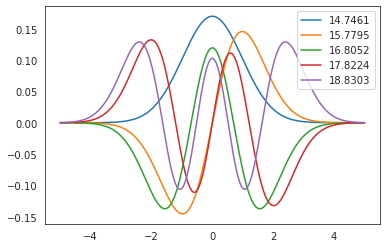

In [111]:
for i in range(5):
    plt.plot(x,psi[:,i], label=f"{energy[i]:.4f}")
    plt.legend(loc=1)

- compare the density to free particles

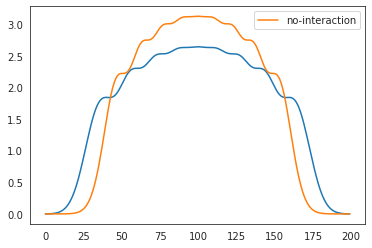

In [112]:
plt.plot(nx)
plt.plot(get_nx(num_electron,psi_harm,x), label="no-interaction")
plt.legend()